In [16]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import holidays

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from varname import nameof

# = = = = = =
# own stuff

from data_prepro import get_energy_data_today

In [4]:
df_energy = get_energy_data_today(to_date="20231201")
print(df_energy.info())
df_energy.tail(5)

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78168 entries, 2014-12-31 23:00:00+00:00 to 2023-12-01 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78168 non-null  datetime64[ns, CET]
 1   gesamt         78168 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75


### Dummy Creation / Feature Engineering

#### holidays

In [ ]:
# get all years in dataframe
uniq_yrs = [2016]

# get holidays for germany for all states and combine them into one single dict
states = ['BB', 'BE', 'BW', 'BY', 'BYP', 'HB', 'HE', 'HH', 'MV', 
            'NI', 'NW', 'RP', 'SH', 'SL', 'SN', 'ST', 'TH']

holidays_de = holidays.CountryHoliday('DE', years=uniq_yrs)
for state in states:
    holidays_de.update(holidays.CountryHoliday('DE', state=state, years=uniq_yrs))

# sort holidays
holidays_de = dict(sorted(holidays_de.items()))
print(holidays_de)

{datetime.date(2016, 1, 1): 'Neujahr', datetime.date(2016, 1, 6): 'Heilige Drei Könige', datetime.date(2016, 3, 25): 'Karfreitag', datetime.date(2016, 3, 27): 'Ostersonntag', datetime.date(2016, 3, 28): 'Ostermontag', datetime.date(2016, 5, 1): 'Erster Mai', datetime.date(2016, 5, 5): 'Christi Himmelfahrt', datetime.date(2016, 5, 15): 'Pfingstsonntag', datetime.date(2016, 5, 16): 'Pfingstmontag', datetime.date(2016, 5, 26): 'Fronleichnam', datetime.date(2016, 8, 15): 'Mariä Himmelfahrt', datetime.date(2016, 10, 3): 'Tag der Deutschen Einheit', datetime.date(2016, 10, 31): 'Reformationstag', datetime.date(2016, 11, 1): 'Allerheiligen', datetime.date(2016, 11, 16): 'Buß- und Bettag', datetime.date(2016, 12, 25): 'Erster Weihnachtstag', datetime.date(2016, 12, 26): 'Zweiter Weihnachtstag'}


#### feature engineering for trees

In [5]:
def features_for_tree(df):

    df_out = df.copy()

    # add hour
    df_out["hour"] = df_out['timestamp_CET'].dt.hour
    # add weekday
    df_out["weekday"] = df_out['timestamp_CET'].dt.weekday
    # add month
    df_out["month"] = df_out['timestamp_CET'].dt.month
    # add weeknum
    df_out["weeknum"] = df_out['timestamp_CET'].dt.isocalendar().week

    # get all years in dataframe
    uniq_yrs = df_out['timestamp_CET'].dt.year.unique()

    # get holidays for germany for all states and combine them into one single dict
    states = ['BB', 'BE', 'BW', 'BY', 'BYP', 'HB', 'HE', 'HH', 'MV',
            'NI', 'NW', 'RP', 'SH', 'SL', 'SN', 'ST', 'TH']

    holidays_de = holidays.CountryHoliday('DE', years=uniq_yrs)
    for state in states:
        holidays_de.update(holidays.CountryHoliday('DE', state=state, years=uniq_yrs))

    # sort holidays
    holidays_de_dates = list(holidays_de.keys())

    # add holiday
    df_out["holiday"] = df_out['timestamp_CET'].isin(holidays_de_dates).astype(int)

    df_out.drop(columns=["timestamp_CET"], inplace=True)

    return df_out

#### create dummies

In [6]:
def create_dummy_df(df, hour_method='simple', holiday_method='simple'):

    df_out = df.copy()

    # binary dummy var for each month
    dummy_month = pd.get_dummies(df_out['timestamp_CET'].dt.month, prefix='month').astype(int)
    # leave out first month to avoid multicollinearity
    dummy_month = dummy_month.iloc[:, 1:]

    # binary dummy var for each weekday
    dummy_weekday = pd.get_dummies(df_out['timestamp_CET'].dt.weekday, prefix='weekday').astype(int)
    # leave out first weekday to avoid multicollinearity
    dummy_weekday = dummy_weekday.iloc[:, 1:]

    # - - - - - - - - -
    # concat dummies
    df_out = pd.concat([df_out, dummy_month], axis=1)
    df_out = pd.concat([df_out, dummy_weekday], axis=1)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # create hour dummies

    if hour_method == 'simple':

        # binary dummy var for each hour
        dummy_hour = pd.get_dummies(df_out['timestamp_CET'].dt.hour, prefix='hour').astype(int)
        # leave out first hour to avoid multicollinearity
        dummy_hour = dummy_hour.iloc[:, 1:]
        df_out = pd.concat([df_out, dummy_hour], axis=1)

    if hour_method == 'seasonal':

        # separate hourly dummy vars for summer and winter months
        summer_months = [4, 5, 6, 7, 8, 9]
        df_out['is_summer'] = df_out['timestamp_CET'].dt.month.isin(summer_months).astype(int)

        # create dummy variables for each hour in summer months
        for hr in range(1, 24):
            # skip hour 0 in summer to avoid multicollinearity
            df_out[f'hour_{hr}_summer'] = ((df_out['is_summer'] == 1) & (df_out['timestamp_CET'].dt.hour == hr)).astype(int)

        for hr in range(1, 24):
            # skip hour 0 in winter to avoid multicollinearity
            df_out[f'hour_{hr}_winter'] = ((df_out['is_summer'] == 0) & (df_out['timestamp_CET'].dt.hour == hr)).astype(int)

        # drop is_summer
        df_out.drop(columns=['is_summer'], inplace=True)

    if hour_method == 'monthly':

        # separate hourly dummy vars for EVERY month
        month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
                    6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',
                    11: 'November', 12: 'December'}

        for m_idx in range(1, 13):
            
            m_name = month_dict[m_idx][:3].lower() # short version of month name

            for hr in range(1, 24):
                # skip hour 0 to avoid multicollinearity
                df_out[f'hour_{hr}_{m_name}'] = ((df_out['timestamp_CET'].dt.month == m_idx) & 
                                                 (df_out['timestamp_CET'].dt.hour == hr)).astype(int)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # create holiday dummies

    # get all years in dataframe
    uniq_yrs = df_out['timestamp_CET'].dt.year.unique()

    # get holidays for germany for all states and combine them into one single dict
    states = ['BB', 'BE', 'BW', 'BY', 'BYP', 'HB', 'HE', 'HH', 'MV', 
              'NI', 'NW', 'RP', 'SH', 'SL', 'SN', 'ST', 'TH']
    
    holidays_de = holidays.CountryHoliday('DE', years=uniq_yrs)
    for state in states:
        holidays_de.update(holidays.CountryHoliday('DE', state=state, years=uniq_yrs))

    # sort holidays
    holidays_de = dict(sorted(holidays_de.items()))
    holidays_de_dates = list(holidays_de.keys())

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    # only one holiday dummy for all holidays
    if holiday_method == 'simple':

        df_out['is_holiday'] = df_out['timestamp_CET'].dt.date.isin(holidays_de_dates).astype(int)

    # create separate dummies for each holiday ...
    if holiday_method == 'separate' :

        # newyears + silvester ist kein feiertag aber die meisten nehmen trotzdem frei
        # create dummy variable for all rows where timestamp_CET is 12.31 or 01.01
        df_out['is_holiday_newyear_d31'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 31))
        df_out['is_holiday_newyear_d01'] = ((df_out['timestamp_CET'].dt.month == 1) & (df_out['timestamp_CET'].dt.day == 1))

        # Heilige Drei Könige (01.06)
        threekings_dates = [k for k, v in holidays_de.items() if v == 'Heilige Drei Könige']
        df_out['is_holiday_threekings'] = df_out['timestamp_CET'].dt.date.isin(threekings_dates)

        # Karfreitag (easter - 2d)
        karfreitag_dates = [k for k, v in holidays_de.items() if v == 'Karfreitag']
        df_out['is_holiday_karfreitag'] = df_out['timestamp_CET'].dt.date.isin(karfreitag_dates)

        # Eastermonday (easter + 1d)
        easter_dates = [k for k, v in holidays_de.items() if v == 'Ostermontag']
        df_out['is_holiday_easter'] = df_out['timestamp_CET'].dt.date.isin(easter_dates)

        # Erster Mai / Tag der Arbeit (05.01)
        erstermai_dates = [k for k, v in holidays_de.items() if v == 'Erster Mai']
        df_out['is_holiday_erstermai'] = df_out['timestamp_CET'].dt.date.isin(erstermai_dates)

        # Christi Himmelfahrt (easter + 39d)
        himmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Christi Himmelfahrt']
        df_out['is_holiday_himmelfahrt'] = df_out['timestamp_CET'].dt.date.isin(himmelfahrt_dates)

        # Pfingstmontag (easter + 50d)
        pfingstmontag_dates = [k for k, v in holidays_de.items() if v == 'Pfingstmontag']
        df_out['is_holiday_pfingstmontag'] = df_out['timestamp_CET'].dt.date.isin(pfingstmontag_dates)

        # Fronleichnam (easter + 60d)
        fronleichnam_dates = [k for k, v in holidays_de.items() if v == 'Fronleichnam']
        df_out['is_holiday_fronleichnam'] = df_out['timestamp_CET'].dt.date.isin(fronleichnam_dates)

        # Maria Himmelfahrt (08.15)
        mariahimmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Mariä Himmelfahrt']
        df_out['is_holiday_mariahimmelfahrt'] = df_out['timestamp_CET'].dt.date.isin(mariahimmelfahrt_dates)

        # Tag der Deutschen Einheit (10.03)
        einheit_dates = [k for k, v in holidays_de.items() if v == 'Tag der Deutschen Einheit']
        df_out['is_holiday_einheit'] = df_out['timestamp_CET'].dt.date.isin(einheit_dates)

        # Reformationstag (10.31)
        reformationstag_dates = [k for k, v in holidays_de.items() if v == 'Reformationstag']
        df_out['is_holiday_reformationstag'] = df_out['timestamp_CET'].dt.date.isin(reformationstag_dates)

        # Allerheiligen (11.01)
        allerheiligen_dates = [k for k, v in holidays_de.items() if v == 'Allerheiligen']
        df_out['is_holiday_allerheiligen'] = df_out['timestamp_CET'].dt.date.isin(allerheiligen_dates)

        # christmas = list of datetimes from 12.24 to 12.26 
        df_out['is_holiday_xmas_d23'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 23))
        df_out['is_holiday_xmas_d24'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 24))
        df_out['is_holiday_xmas_d25'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 25))
        df_out['is_holiday_xmas_d26'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day == 26))

        # brückentage zwischen weihnachten und neujahr
        # 12.27, 12.28, 12.29, 12.30
        df_out['is_holiday_xmas2newyear'] = ((df_out['timestamp_CET'].dt.month == 12) & (df_out['timestamp_CET'].dt.day.isin([27,28,29,30])))

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
        # reformat all columns that begin with "is_holiday" to int
        for col in df_out.columns:
            if col.startswith('is_holiday'):
                df_out[col] = df_out[col].astype(int)

    return df_out

### Lin Reg

In [7]:
def fit_lin_reg(df, method='ols', test_perc=0.01, drop_cols=None, title_addon=None):

    if drop_cols is None:
        drop_cols = ['timestamp_CET']
    else:
        drop_cols.append('timestamp_CET')

    # drop columns
    df = df.drop(drop_cols, axis=1)

    # do train test split manually
    n_total = df.shape[0]
    n_train = int((1-test_perc) * n_total)
    n_test = n_total - n_train

    X_train = df.iloc[:n_train]
    X_test = df.iloc[-n_test:]

    y_train = X_train['gesamt']
    y_test = X_test['gesamt']

    X_train = X_train.drop(['gesamt'], axis=1)
    X_test = X_test.drop(['gesamt'], axis=1)

    # Add a constant term to the features matrix for statsmodels
    X_train = sm.add_constant(X_train)
    # Create model using OLS (Ordinary Least Squares)
    model = sm.OLS(y_train, X_train)

    if method == 'ols' :

        results = model.fit()
        print(results.summary())

        r_sqrd = results.rsquared
        r_sqrd_adj = results.rsquared_adj

    elif method == 'ridge' :

        results = model.fit_regularized(method = 'elastic_net')
        print(results.params.to_string())
        # [TODO] how to get r squared ???

    # Add a constant term to the features matrix for the test set
    X_test = sm.add_constant(X_test, has_constant='add')

    # PROBLEM eg if first column is "is_summer" and the test set is in summer, then the first column is already constant = 1 everywhere
    # BUT we still want to add a constant row to make sure the model works / has the right dimension
    # SO we set has_constant = 'add' to force the constant row to be added

    # Make predictions
    y_pred = results.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")

    title = f"Lin Reg using {method} and {len(X_train.columns)} predictors"
    
    if method == 'ols' :
        title = f"{title}, r2={r_sqrd:.4f}, r2_adj={r_sqrd_adj:.4f}"
    # if method == 'ridge' :
    #     title = ...
    
    title = f"{title}, {title_addon}"

    # Plot out of sample predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_test, label='test')
    plt.plot(y_test.index, y_pred, label=f'predicted, rmse = {rmse:.2f}')
    
    plt.title(title)
    plt.legend()
    plt.show()

    return X_train, X_test, y_train, y_test, results, y_pred


                            OLS Regression Results                            
Dep. Variable:                 gesamt   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     4717.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:52:01   Log-Likelihood:            -2.8265e+05
No. Observations:               29328   AIC:                         5.654e+05
Df Residuals:                   29286   BIC:                         5.657e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.499e+04    135.470    405.944      0.0

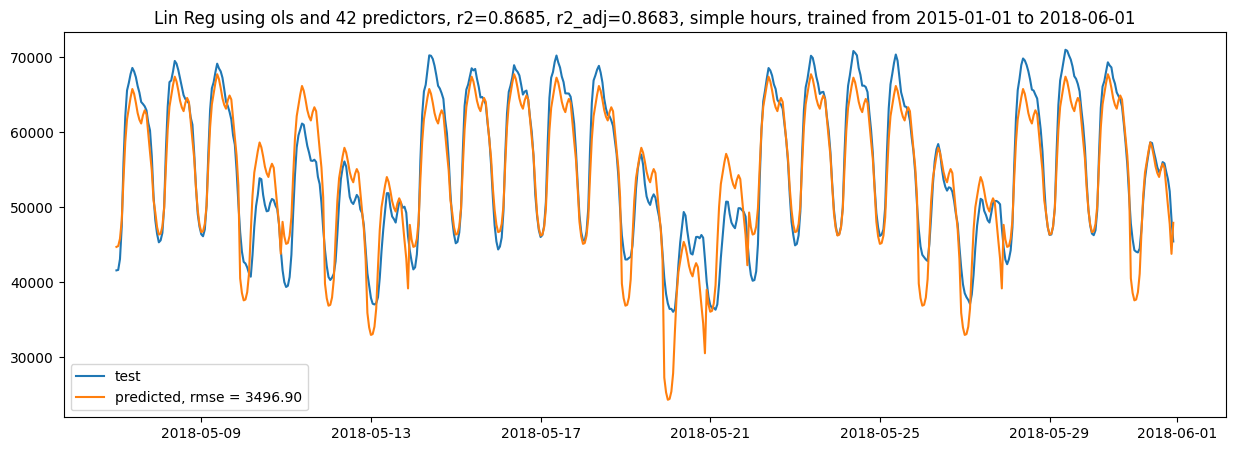

const         54688.465838
month_2         261.675391
month_3       -2244.666581
month_4       -5817.269382
month_5       -7311.052499
month_6       -7441.380271
month_7       -7345.723107
month_8       -8286.527125
month_9       -7087.931306
month_10      -4597.925365
month_11       -880.820042
month_12      -2957.697085
weekday_1      1691.408821
weekday_2      2016.770832
weekday_3      1561.986218
weekday_4       450.058237
weekday_5     -7781.843324
weekday_6    -11677.996852
hour_1        -1704.768772
hour_2        -2696.389437
hour_3        -2584.116853
hour_4        -1604.441730
hour_5          830.183474
hour_6         6346.145831
hour_7        11275.945340
hour_8        14316.131306
hour_9        15793.782288
hour_10       17199.746690
hour_11       18335.545995
hour_12       17692.609415
hour_13       16501.031879
hour_14       15127.237280
hour_15       14245.158720
hour_16       13742.564203
hour_17       14841.178769
hour_18       15502.025741
hour_19       14973.849800
h

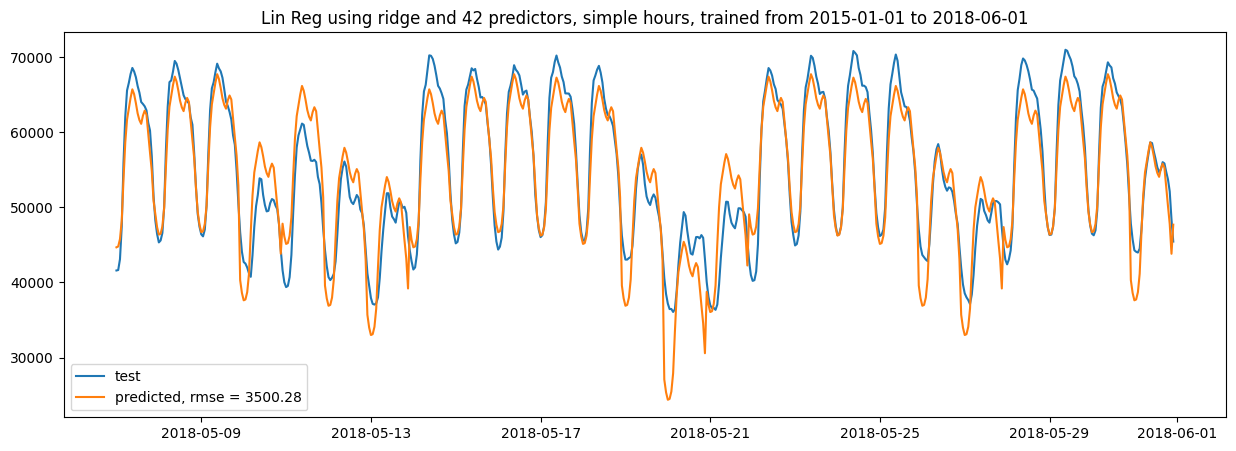

In [8]:
hr_meths = ['simple', 'seasonal', 'monthly']
hr_meths = ['simple']

for hour_method in hr_meths:

    df_energy_dummy = create_dummy_df(df_energy, hour_method=hour_method)

    # take smaller dataset
    start = '2015-01-01'
    end = '2018-06-01'
    df_energy_dummy_small = df_energy_dummy.loc[(df_energy_dummy['timestamp_CET'] > start) & 
                                                (df_energy_dummy['timestamp_CET'] <= end)]
                                                
    # fit model on all data and another fit without "is_weekend" and "is_night"
    title_add = f'{hour_method} hours, trained from {start} to {end}'
    res = fit_lin_reg(df_energy_dummy_small, test_perc=0.02, method='ols', title_addon=title_add)
    res = fit_lin_reg(df_energy_dummy_small, test_perc=0.02, method='ridge', title_addon=title_add)


### Random Forest / XGBoost / LightGBM

In [9]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#### train test split

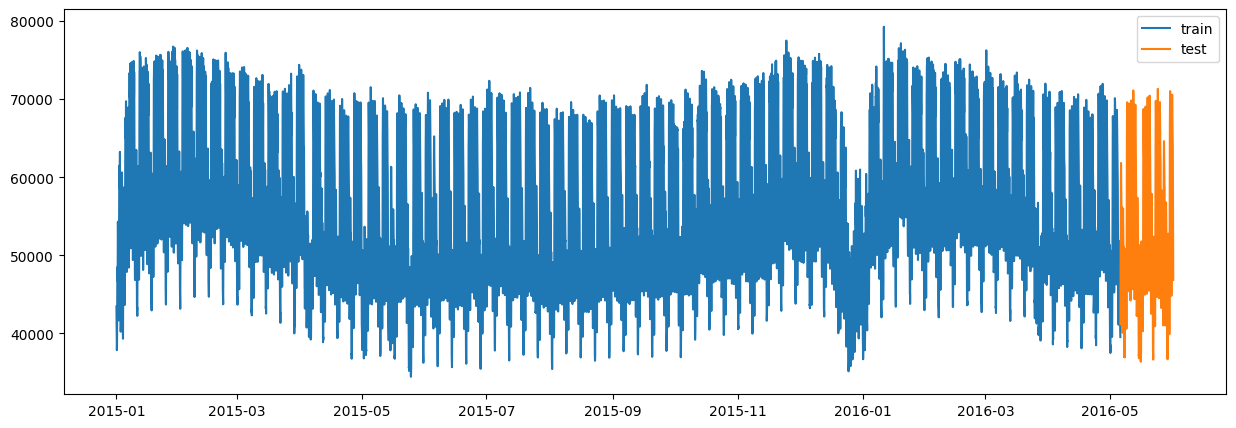

In [63]:
# take smaller dataset
start   = '2015-01-01'
end     = '2016-06-01'
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]
        
df = features_for_tree(df_energy_small)
test_perc = 0.05

# - - - - - - - - - - - - - -
# train test split for random forests

n_total = df.shape[0]
n_train = int((1-test_perc) * n_total)
n_test = n_total - n_train

X_train = df.iloc[:n_train]
X_test = df.iloc[-n_test:]

y_train = X_train['gesamt']
y_test = X_test['gesamt']

X_train = X_train.drop(['gesamt'], axis=1)
X_test = X_test.drop(['gesamt'], axis=1)

# - - - - - - - - - - - - - -
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='train')
plt.plot(y_test, label='test')
plt.legend()
plt.show()

#### param grid search

In [11]:
# = = = = = = 
# XGBoost
# = = = = = = 

# cv_split = TimeSeriesSplit(n_splits=2, test_size=100)
# model = XGBRegressor()
# parameters = {
#     "max_depth": [3, 5, 10],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "n_estimators": [100, 200, 300],
#     "colsample_bytree": [0.3, 0.5, 0.8]
# }

# grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
# grid_search.fit(X_train, y_train)

# # Accessing the best parameters
# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

# = = = = = = 
# Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
# = = = = = = 

In [12]:
# # In-sample predictions 
# y_train_pred = xgboost_model.predict(X_train)
# # Out-of-sample predictions
# y_test_pred = xgboost_model.predict(X_test)

# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 5))

# ax1.plot(y_train, label='actual')
# ax1.plot(y_train.index, y_train_pred, label='in sample predictions')

# ax2.plot(y_test, label='actual')
# ax2.plot(y_test.index, y_test_pred, label='out of sample predictions')

# plt.show()

In [13]:
# = = = = = = 
# LGBM
# = = = = = = 

# cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
# model = lgb.LGBMRegressor()
# parameters = {
#     "max_depth": [3, 5, 10],
#     "num_leaves": [10, 50, 100],
#     "learning_rate": [0.01, 0.1, 0.3],
#     "n_estimators": [50, 200, 500],
#     "colsample_bytree": [0.3, 0.7, 1],
#     "verbose": [-1]
# }

# grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
# grid_search.fit(X_train, y_train)

# # Accessing the best parameters
# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

# ERROR
# [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
# 1) the num_leaves is too large, you can set it to a smaller value
# 2) the min_data is too large
# 3) your data is hard to fit

# = = = = = = 
# Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'num_leaves': 10, 'verbose': -1}
# = = = = = = 

In [14]:
# # In-sample predictions 
# y_train_pred = lgbm_model.predict(X_train)
# # Out-of-sample predictions
# y_test_pred = lgbm_model.predict(X_test)

# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 5))

# ax1.plot(y_train, label='actual')
# ax1.plot(y_train.index, y_train_pred, label='in sample predictions')

# ax2.plot(y_test, label='actual')
# ax2.plot(y_test.index, y_test_pred, label='out of sample predictions')

# plt.show()

### [ALL] model fits n eval

#### data split

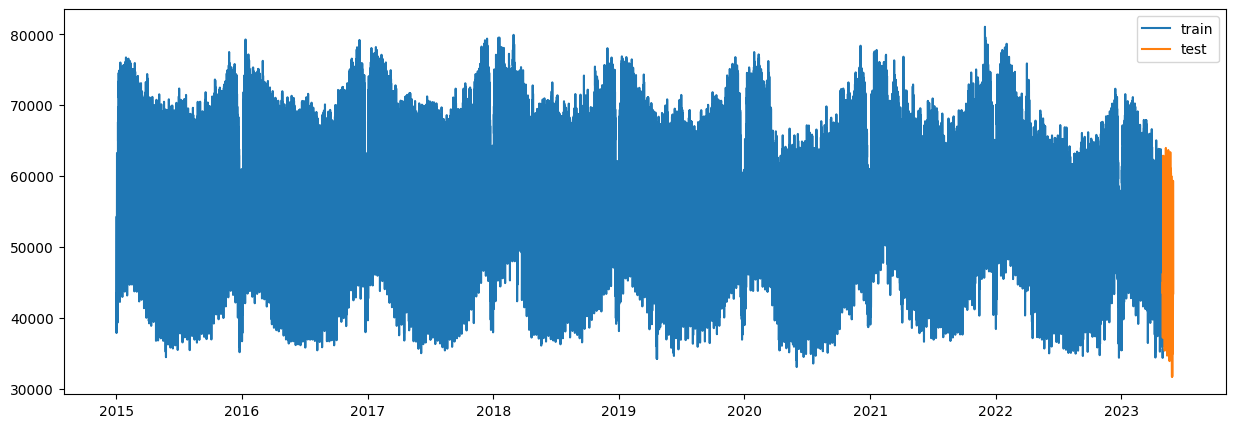

In [73]:
# take smaller dataset
start   = '2015-01-01'
end     = '2023-06-01'
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]
        
df = features_for_tree(df_energy_small)
test_perc = 0.01

# - - - - - - - - - - - - - -
# train test split for random forests

n_total = df.shape[0]
n_train = int((1-test_perc) * n_total)
n_test = n_total - n_train

X_train = df.iloc[:n_train]
X_test = df.iloc[-n_test:]

y_train = X_train['gesamt']
y_test = X_test['gesamt']

X_train = X_train.drop(['gesamt'], axis=1)
X_test = X_test.drop(['gesamt'], axis=1)

# - - - - - - - - - - - - - -
# train test split for regression

df = create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='simple')

X_train_reg = df.iloc[:n_train].drop(['timestamp_CET', 'gesamt'], axis=1)
X_test_reg = df.iloc[-n_test:].drop(['timestamp_CET', 'gesamt'], axis=1)

X_train_reg = sm.add_constant(X_train_reg, has_constant='add').astype(float)
X_test_reg = sm.add_constant(X_test_reg, has_constant='add').astype(float)

# - - - - - - - - - - - - - -
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='train')
plt.plot(y_test, label='test')
plt.legend()
plt.show()

#### fit

In [74]:
# create model with best parameters
xgboost_model = XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=200)
xgboost_model.fit(X_train, y_train)

# create model with best parameters
lgbm_model = lgb.LGBMRegressor(colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=50, num_leaves=10, verbose=-1)
lgbm_model.fit(X_train, y_train)

# OLS models
ols_model = sm.OLS(y_train, X_train_reg)
ols_results = ols_model.fit()
elanet_results = ols_model.fit_regularized(method = 'elastic_net')

print('fit complete')

fit complete


#### eval

Model: XGBoost
MAE  :         5120.82
RMSE :         6646.89
MAPE :            0.11
- - - - - - - - - - 
Model: LGBM
MAE  :         5196.13
RMSE :         6774.67
MAPE :            0.11
- - - - - - - - - - 
Model: ols_normal
MAE  :         5297.55
RMSE :         6102.30
MAPE :            0.11
- - - - - - - - - - 
Model: ols_elanet
MAE  :         5290.98
RMSE :         6095.21
MAPE :            0.11
- - - - - - - - - - 


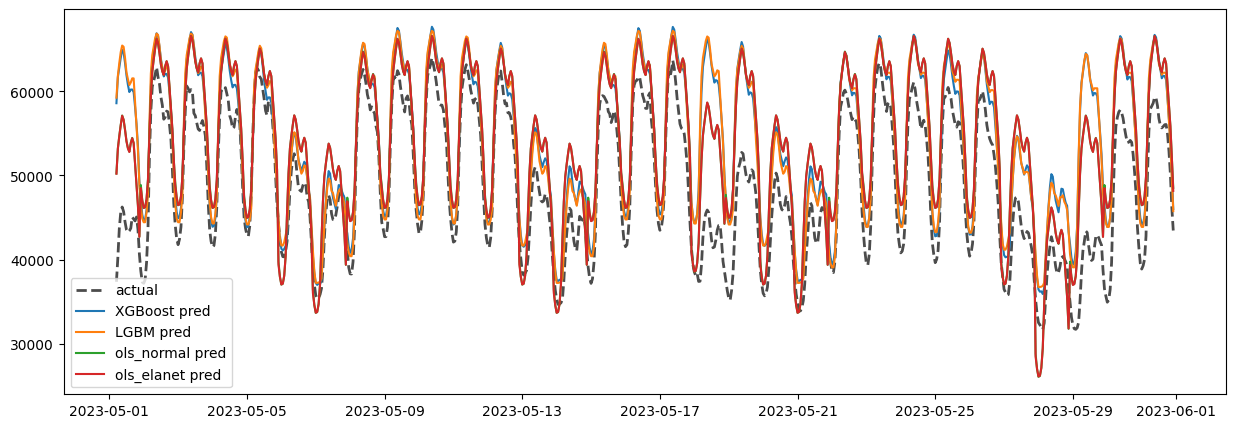

In [75]:
models = [xgboost_model, lgbm_model, ols_results, elanet_results]
names = ['XGBoost', 'LGBM', 'ols_normal', 'ols_elanet']

plt.figure(figsize=(15, 5))
plt.plot(y_test, color='black', lw=2, ls='--', label='actual', alpha=0.7)

for model_idx, model in enumerate(models):
    
    model_name = names[model_idx]

    if model_name.startswith('ols') :

        # In-sample predictions 
        y_train_pred = model.predict(X_train_reg).astype(float)
        # Out-of-sample predictions
        y_test_pred = model.predict(X_test_reg).astype(float)

    else :

        # In-sample predictions 
        y_train_pred = model.predict(X_train)
        # Out-of-sample predictions
        y_test_pred = model.predict(X_test)

    print(f"Model: {names[model_idx]}")
    print(f"MAE  : {mean_absolute_error(y_test, y_test_pred):>15.2f}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_test_pred)):>15.2f}")
    print(f"MAPE : {mean_absolute_percentage_error(y_test, y_test_pred):>15.2f}")
    print('- ' * 10)

    plt.plot(y_test.index, y_test_pred, label=f'{names[model_idx]} pred')

plt.legend()
plt.show()
